# Информация о датасете

Для итогового проекта был выбран [датасет с Kaggle](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db?resource=download), который содержит информацию о более чем 232 тысяч песен, доступных на Spotify.

Датасет содержит 18 столбцов:
- `track_id` - уникальный идентификатор трека в Spotify
- `track_name` - название трека
- `artist_name` - исполнитель трека 
- `danceability` - показатель танцевальности трека (от 0 до 1)
- `energy` - показатель энергичности трека (от 0 до 1)
- `key` - тональность трека
- `loudness` - громкость трека (в децибелах)
- `mode` - лад трека (мажорный или минорный)
- `speechiness` - показатель речевости трека (от 0 до 1)
- `acousticness` - показатель акустичности трека (от 0 до 1)
- `instrumentalness` - показатель инструментальности трека (от 0 до 1)
- `liveness` - показатель живости трека (от 0 до 1)
- `valence` - показатель эмоциональной окраски трека (от 0 до 1)
- `tempo` - темп трека (в BPM)
- `duration_ms` - длительность трека (в миллисекундах)
- `time_signature`- размерность трека (количество долей в такте)


# Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc, log_loss, accuracy_score 
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
warnings.filterwarnings("ignore")
sns.set_palette('YlGn_d')

In [ ]:
df = pd.read_csv('SpotifyFeatures.csv')
df.head(3)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.0,C,0.103,-13.879,Minor,0.0362,99.488,5/4,0.368


# Разведочный анализ

Рассмотрим общую информацию о каждом столбце: тип данных, нулевые значения, количество уникальных данных и уникальные данные столбца.


In [ ]:
def data_desc():
  columns = []
  for col in df.columns:
    columns.append([col, df[col].dtypes, df.shape[0], df[col].isnull().sum(),
                    df[col].nunique(), list(df[col].unique())])
    desc = pd.DataFrame(data=columns, columns=['column', 'dtype', 'count', 'null', 'unique', 'unique_sample'])
  return desc

data_desc()

,column,dtype,count,null,unique,unique_sample
0,genre,object,232725,0,27,"[Movie, R&B, A Capella, Alternative, Country, ..."
1,artist_name,object,232725,0,14564,"[Henri Salvador, Martin & les fées, Joseph Wil..."
2,track_name,object,232725,0,148615,"[C'est beau de faire un Show, Perdu d'avance (..."
3,track_id,object,232725,0,176774,"[0BRjO6ga9RKCKjfDqeFgWV, 0BjC1NfoEOOusryehmNud..."
4,popularity,int64,232725,0,101,"[0, 1, 3, 4, 2, 15, 10, 8, 5, 6, 7, 11, 65, 63..."
5,acousticness,float64,232725,0,4734,"[0.611, 0.246, 0.952, 0.703, 0.95, 0.749, 0.34..."
6,danceability,float64,232725,0,1295,"[0.389, 0.59, 0.663, 0.24, 0.331, 0.578, 0.703..."
7,duration_ms,int64,232725,0,70749,"[99373, 137373, 170267, 152427, 82625, 160627,..."
8,energy,float64,232725,0,2517,"[0.91, 0.737, 0.131, 0.326, 0.225, 0.0948, 0.2..."
9,instrumentalness,float64,232725,0,5400,"[0.0, 0.123, 0.00086, 0.00125, 0.529, 0.887, 0..."


Проверим датасет на наличие дупликатов, все записи уникальны.

In [ ]:
print(f'Количество дупликатов: {sum(df.duplicated())}')

Количество дупликатов: 0


Рассмотрим основные статистические показатели для числовых переменных.

In [ ]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


Рассмотрим наиболее популярные композиции среди самых популярных жанров.

In [ ]:
data_popular_genre = pd.DataFrame()
popular_genre = df.groupby(['genre']).median()['popularity'].sort_values(ascending=False).index[:5]

for genre in popular_genre:
  popular_tracks = df[df['genre'] == genre].sort_values(by='popularity', ascending=False).head(5)
  data_popular_genre = data_popular_genre.append(popular_tracks)

fig = px.sunburst(data_popular_genre, path=['genre', 'artist_name', 'track_name'], values='popularity', 
                 color='popularity', color_continuous_scale='YlGn')
fig.update_layout(title_text='Топ-5 треков среди популярнейших жанров', title_x=0.475)
fig.show()

Помимо жанров с наибольшей популярностью и информации о треке и артисте можно заметить следующее: 
*  у трека может быть несколько исполнителей (Going Bad (feat. Drake))
*  у трека может быть несколько жанров (7 rings, Wow.)

## Первичный анализ признаков

`track_id` содержит всего 176774 уникальных значений, а строк 232725. Мы выяснили, что один трек может содержать несколько записей, различающихся лишь столбцом `genre`. Избежим дублирования, будем хранить в `genre` массив из всех встречающихся у трека жанров. 

In [ ]:
data = df.copy()
data['genre'] = data.genre.apply(lambda x: x.replace('Children’s Music', "Children's Music")) # исправляем неправильное написание жанра

columns = list(data.columns.drop('genre'))
data = data.groupby(columns)['genre'].agg(list).reset_index()
data.drop_duplicates(subset=['track_id'], inplace=True)

data.reset_index(drop=True , inplace=True) #сбросим индекс
data.head(3)

,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,!!!,All U Writers,2pPhbWZBm3Q6b35jV691qG,40,0.00412,0.874,322623,0.814,0.464000,B,0.069,-6.873,Minor,0.0450,121.976,4/4,0.741,[Electronic]
1,!!!,Bend Over Beethoven,5PRM1a5qRJpsFzkz8VyRUY,36,0.00310,0.630,486813,0.927,0.739000,A,0.182,-6.540,Major,0.0457,120.654,4/4,0.611,[Electronic]
2,!!!,Californiyeah,5OAv07sMKALt6qWV3q90J8,36,0.02490,0.865,274013,0.650,0.000391,A,0.102,-8.025,Minor,0.1010,120.030,4/4,0.557,[Electronic]



### Целевой признак `popularity`.

Рассмотрим распределение популярности среди музыкальных композиций в датасете.

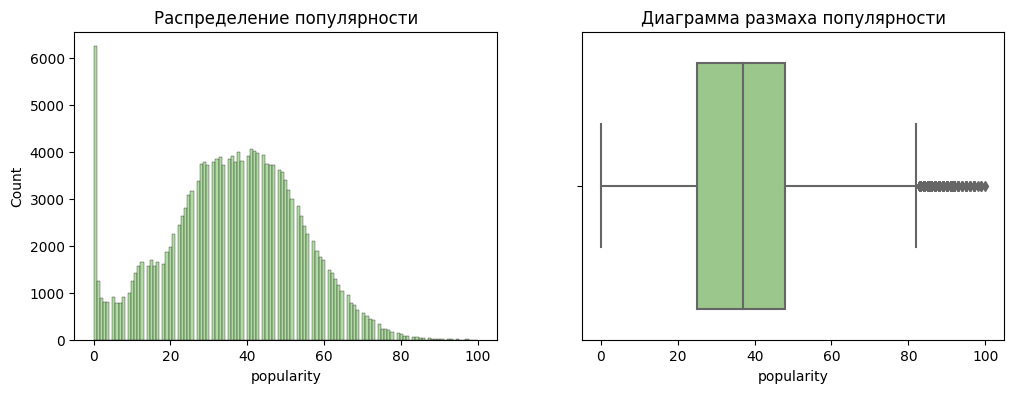

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=data, x='popularity', ax=axis[0])
sns.boxplot(data=data, x='popularity', ax=axis[1])
axis[0].set_title('Распределение популярности')
axis[1].set_title('Диаграмма размаха популярности');

*   очень много нулевых значений
*   медианное значение почти совпадает со средним и близко к 40
*   популярность более 50 имеет менее 25% треков



Введем дополнительный признак `is_popular`. Будем считать трек популярным, если значения популярности для него > 50. 

In [ ]:
data['is_popular'] = 0  # заполняем сначала значения нового признака нулями
data.loc[data['popularity'] > 50, 'is_popular'] = 1

### Количественные признаки

Построим графики распределения количественных признаков:`acousticness`, `dancebility`, `duration_ms`, `energy`, `instrumentalness`, `liveness`, `loudness`, `speechiness`, `tempo`, `valence`. 

In [ ]:
q_features = list(data.select_dtypes(include='number').columns[1:-1])

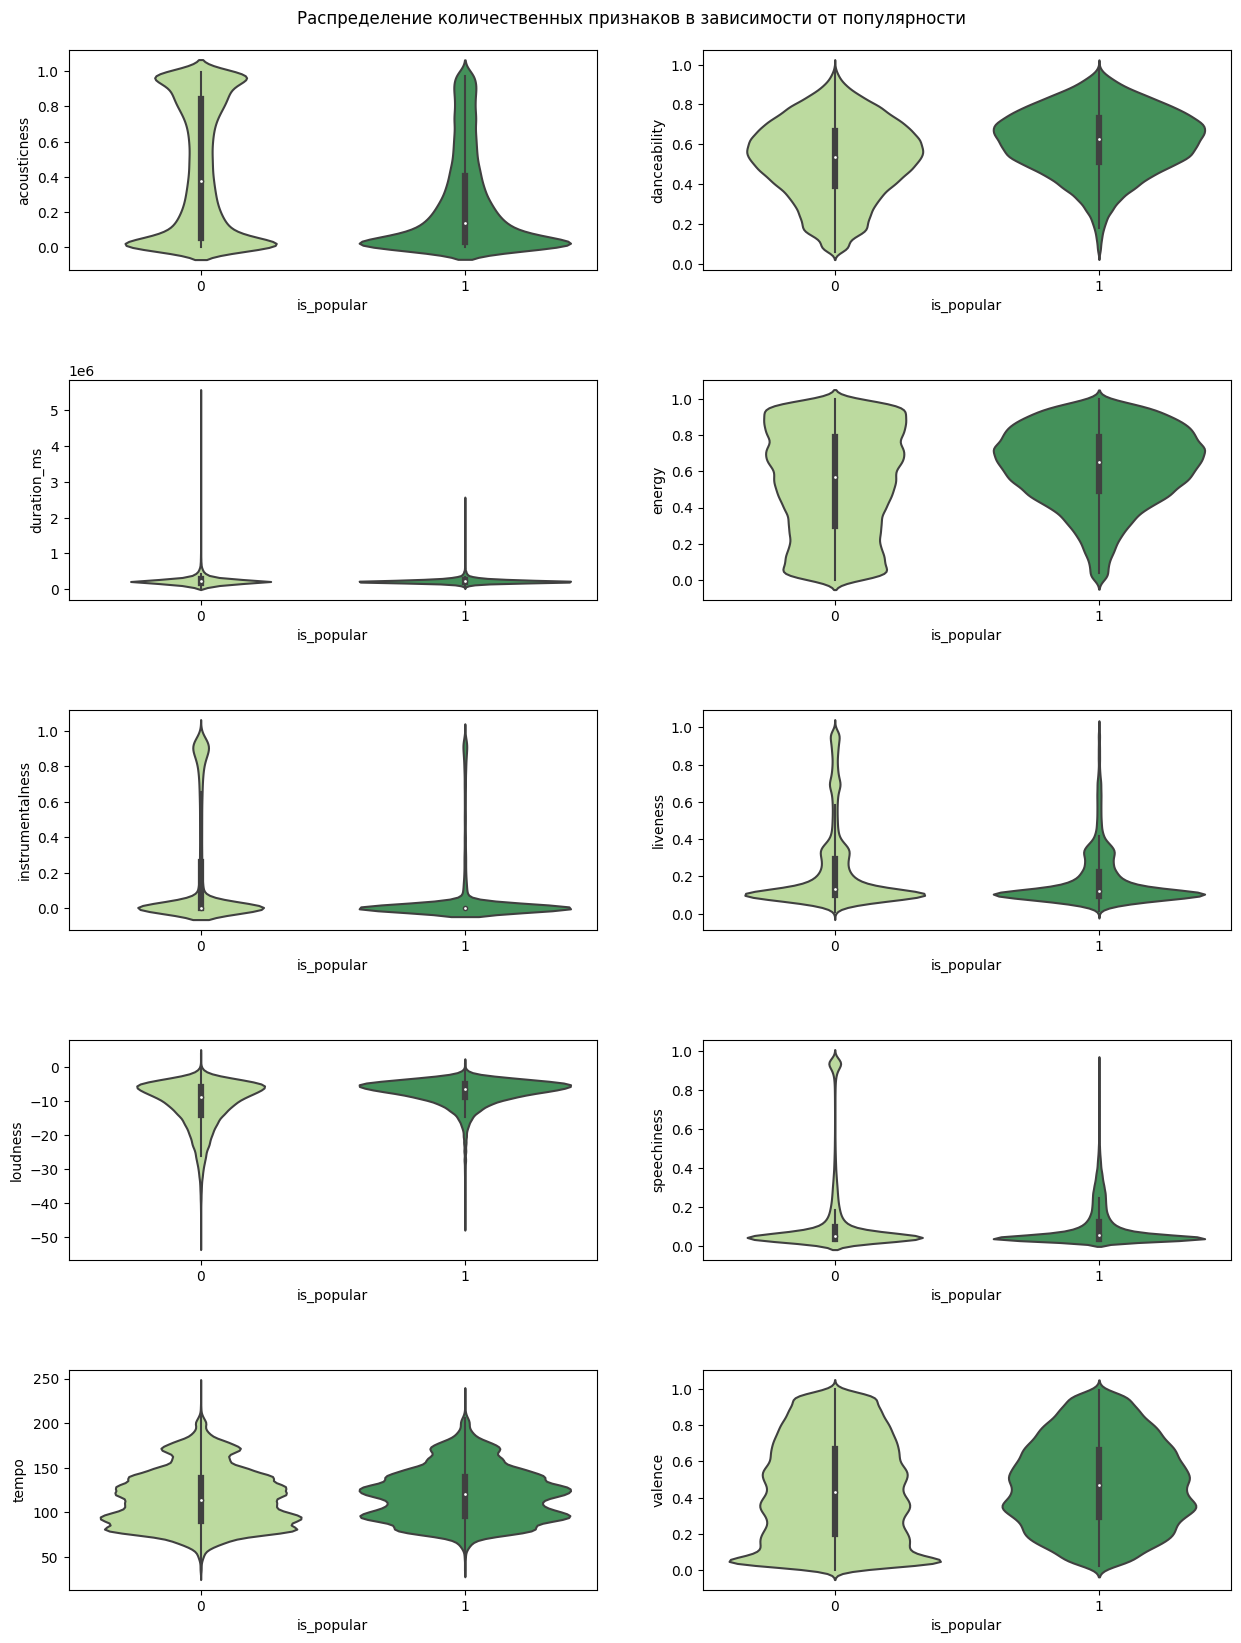

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Распределение количественных признаков в зависимости от популярности', y=0.9)
fig.subplots_adjust(hspace=0.5)

for i, q in enumerate(q_features):
  sns.violinplot(y=data[q], x=data['is_popular'], ax=ax[i//2][i%2], palette='YlGn')

plt.show()

*   Популярные треки менее акустичны
*   Наиболее танцевальные треки более популярны
*   Обычно продолжительность популярных треков немного короче, чем непопулярных
*   В популярных треках наименьшее количество инструментальности
*   С точки зрения живого исполнения распределение признака в популярных и непопулярных треках схожее. Однако непопулярные треки содержат немного больше живого исполнения
*   Средняя громкость популярных треков выше, кроме того, количество более громких песен среди популярных больше, чем среди непопулярных
*   Наиболее популярные треки имеют большую эмоциональную окраску






### Категориальные признаки 

Построим график распределения, иллюстрирующий количество популярных и непопулярных треков в зависимости от жанров.  

In [ ]:
data_genre = df.copy()
data_genre['is_popular'] = 0
data_genre.loc[data_genre['popularity'] > 50, 'is_popular'] = 1
data_genre['genre'] = data_genre.genre.apply(lambda x: x.replace('Children’s Music', "Children's Music")) # исправляем неправильное написание жанра

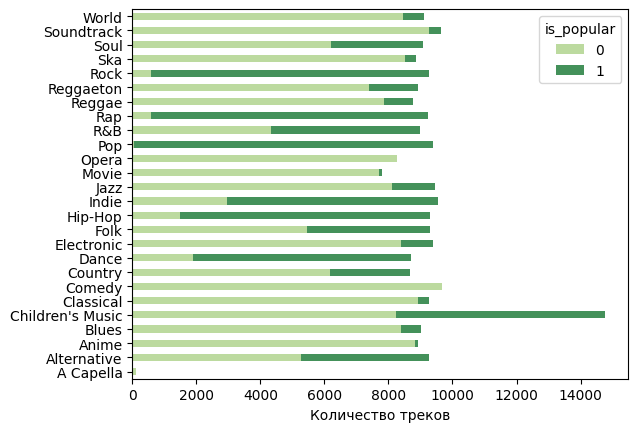

In [ ]:
genres = data_genre.groupby(['genre', 'is_popular'])['track_id'].count().unstack()
genres.fillna(0)
colors = ['#bcda9f', '#44915a']
genres.plot(kind='barh', xlabel='Количество треков', ylabel='', stacked=True, colormap=ListedColormap(colors));

*   Музыка для детей с отрывом лидирует по количеству треков
*   В жанре акапелла около 100 треков
*   Лидером по количеству популярных треков является жанр поп
*   Также наиболее популярными жанрами являются: рок и рэп
*   Наименее популярными жанрами являются: аниме и кино
*   Среди таких жанров, как акапелла, комедия и опера нет ни одной популярной песни

Построим график распределения категориальных признаков:`mode`, `key`,`time_signature`.

In [ ]:
c_features = ['mode', 'key', 'time_signature']

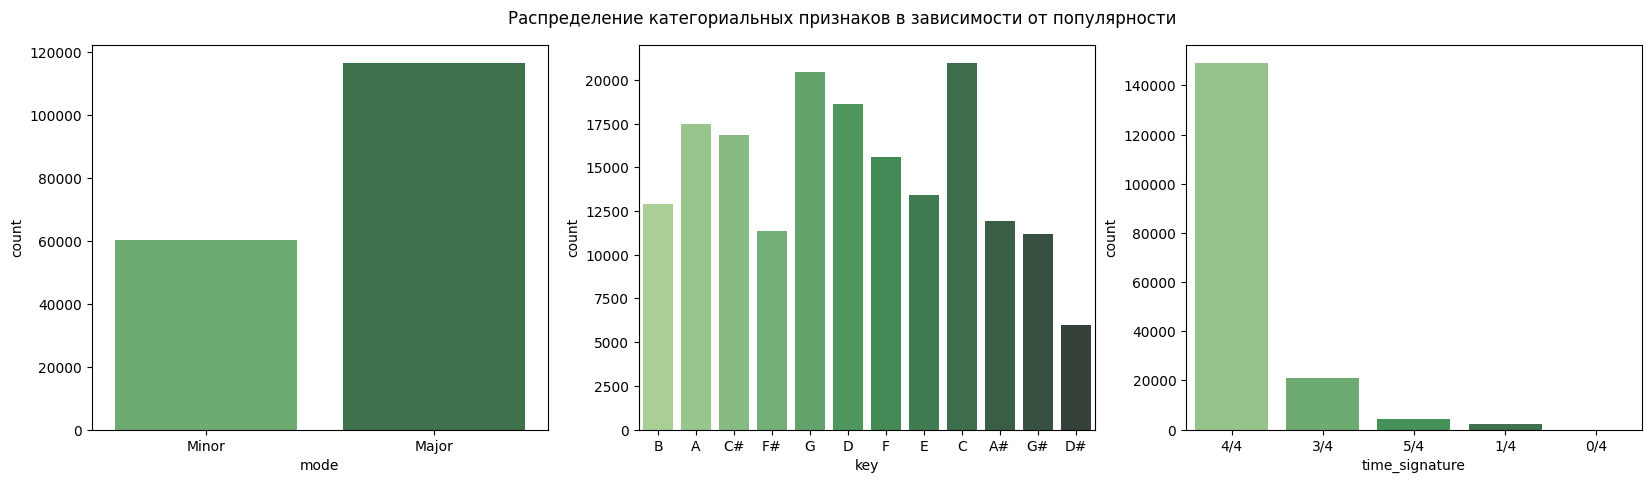

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Распределение категориальных признаков в зависимости от популярности', y=0.95)
fig.subplots_adjust(hspace=0.5)

for i, c in enumerate(c_features):
  sns.countplot(x=c, data=data, ax=ax[i], palette=sns.color_palette('YlGn_d', data[c].nunique()))

*   В категории лад лидируют мажорные треки (более радостные и веселые композиции)
*   Наиболее используемая размерность в музыкальных композициях - четыре четверти
*   Более 20000 треков написаны в тональности C
*   Гаммы G и F являются часто используемыми тональностями во многих музыкальных произведениях





Построим матрицу корреляции для определения взаимосвязи между признаками и выявления наиболее значимых для модели.

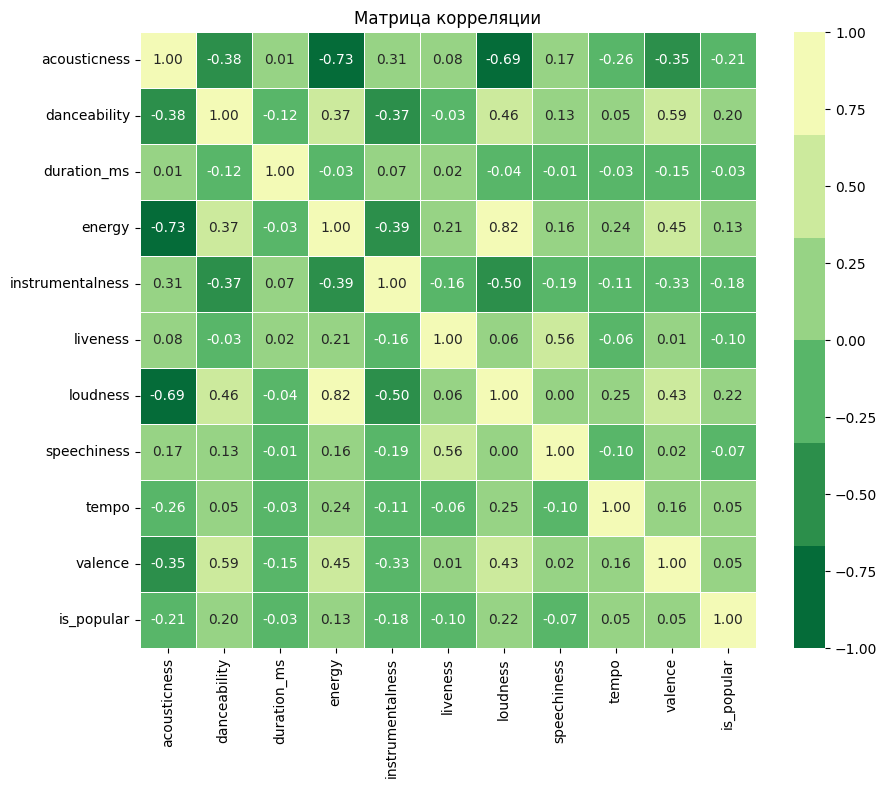

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(data.drop('popularity', axis=1).corr(), annot = True, vmin=-1, vmax=1,
            square=True, fmt='.2f', linewidths=.5, cmap=sns.color_palette('YlGn_r'))
plt.title('Матрица корреляции')
plt.show()

*   Чем энергичнее трек, тем менее он акустичный
*   Чем громче трек, тем менее он акустичный
*   Чем громче трек, тем он более энергичный


# Инженерия признаков

## Выделение новых признаков

Как мы заметили, `track_name` может хранить информацию, был ли трек записан в одиночку или совместно с другими артистами. Выделим новый признак `feat_count`, который будет считать количество артистов, совместно с которыми был записан трек. 

In [ ]:
data['feat_count'] = data['track_name'].str.extract(r'\((feat\.|with)\s*([\w\s, &]+)\)').iloc[:, 1].str.count('[,&]') + 1
data['feat_count'] = data['feat_count'].fillna(0)
data['feat_count'] = data['feat_count'].astype(int)

## Трансформация строк в числа

Для того чтобы наши данные можно было использовать в математических выражениях нам необходимо преобразовать категориальные данные в числовые:
*   `mode` - изменим значение Major -> 1 и Minor -> 0.
*   `time_signature` - заменим на первое числовое значение (т.е.: 4/4 -> 4); это не приведет к удалению информации, потому что все подписи имеют один и тот же знаменатель.
*   `key` - преобразуем в числовые значения от 1 до 12 в соответствии с хроматической шкалой, которая делит тон на 12 тональностей (C, C#, D, D#, E, F, F#, G, G#, A, A#, B).



In [ ]:
mode_dict = {'Major' : 1, 'Minor' : 0}
data['mode'].replace(mode_dict, inplace=True)

data['time_signature'] = data['time_signature'].apply(lambda x : int(x[0]))

key_dict = {'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
            'F#' : 7, 'G' : 8, 'G#' : 9, 'A' : 10, 'A#' : 11, 'B' : 12}
data['key'] = data['key'].replace(key_dict)

## One-hot encoding

Для удобства дальнейшей работы разделим список, содержащий все жанры трека, на разные столбцы.

In [ ]:
#one-hot-encoding к списку в столбце
dummies = pd.get_dummies(data['genre'].apply(pd.Series).stack()).sum(level=0)

#объединение новых столбцов с исходным датафреймом
data = pd.concat([data, dummies], axis=1).drop('genre', axis=1)

pd.set_option('display.max_columns', None)

data.head(3)

,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_popular,feat_count,A Capella,Alternative,Anime,Blues,Children's Music,Classical,Comedy,Country,Dance,Electronic,Folk,Hip-Hop,Indie,Jazz,Movie,Opera,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World
0,!!!,All U Writers,2pPhbWZBm3Q6b35jV691qG,40,0.00412,0.874,322623,0.814,0.464000,12,0.069,-6.873,0,0.0450,121.976,4,0.741,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,!!!,Bend Over Beethoven,5PRM1a5qRJpsFzkz8VyRUY,36,0.00310,0.630,486813,0.927,0.739000,10,0.182,-6.540,1,0.0457,120.654,4,0.611,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,!!!,Californiyeah,5OAv07sMKALt6qWV3q90J8,36,0.02490,0.865,274013,0.650,0.000391,10,0.102,-8.025,0,0.1010,120.030,4,0.557,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Удаление ненужных признаков

Уберем ненужные признаки и повторно построим матрицу корреляции.

In [ ]:
data.drop(['artist_name', 'track_name', 'track_id', 'popularity'], axis=1, inplace=True)

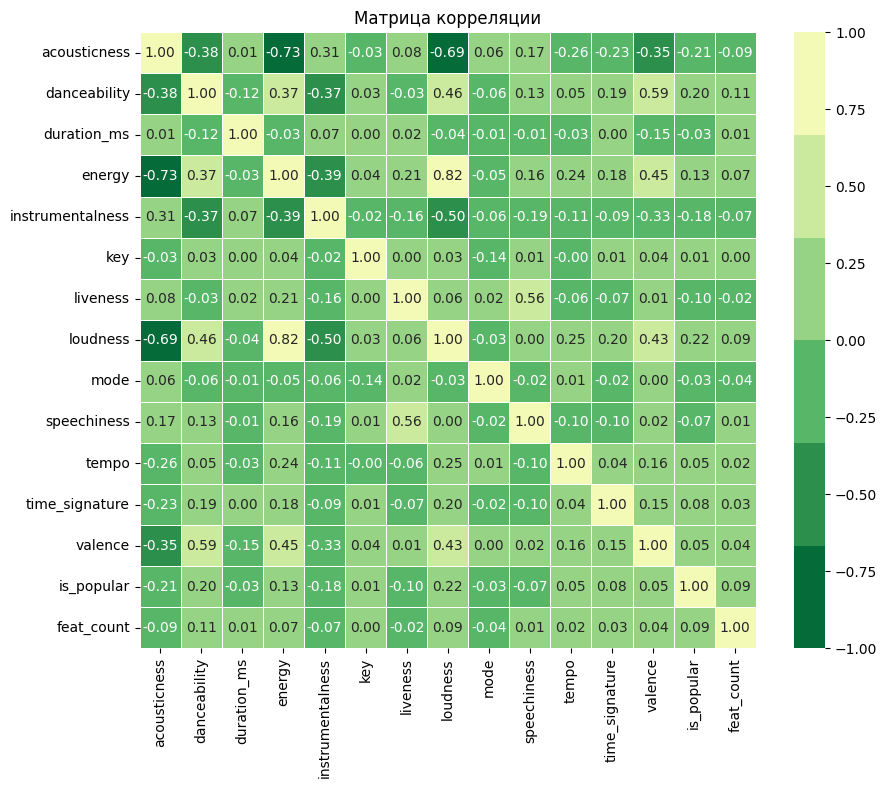

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(data.iloc[:, :15].corr(), annot = True, vmin=-1, vmax=1, square=True, fmt='.2f', 
            linewidths=.5, cmap=sns.color_palette('YlGn_r'))
plt.title('Матрица корреляции')
plt.show()

Существенных изменений в матрице корреляций выявлено не было. `feat_count`, `key`, `mode`, `time_signature` не имеют сильной связи с другими предикторами.

# Методы машинного обучения

Необходимо решить задачу классификации и научиться предсказывать целевой признак `popularity`: станет ли песня популярна или нет.

## Разделение и масштабирование

In [ ]:
X = data.drop('is_popular', 1) 
y = data[['is_popular']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

In [ ]:
sc = StandardScaler() 

X_train_sc = sc.fit_transform(X_train) 
X_test_sc = sc.transform(X_test)

## Построение первой модели



В качестве первой модели была выбрана модель **Логистической регрессии**. Она проста в реализации и эффективна для бинарной классификации.

### Выбор подмножества признаков

In [ ]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train_sc, y_train)

selected_features_log = list(rfecv.get_feature_names_out(X.columns))

print('Оптимальное количество параметров: %d' % rfecv.n_features_)
print('Выбранные параметры: %s' % selected_features_log)

Оптимальное количество параметров: 34
Выбранные параметры: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'time_signature', 'valence', 'A Capella', 'Alternative', 'Anime', 'Blues', 'Classical', 'Comedy', 'Country', 'Dance', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Movie', 'Opera', 'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul', 'Soundtrack', 'World']


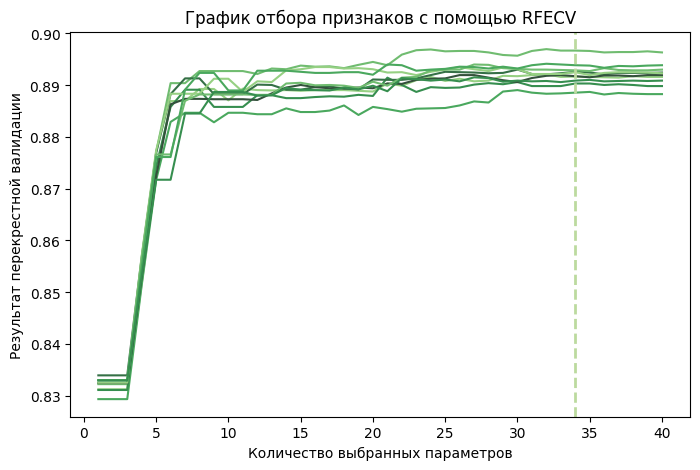

In [ ]:
results = rfecv.cv_results_.copy()
del results['mean_test_score']
del results['std_test_score']

plt.figure(figsize=(8,5))
plt.title('График отбора признаков с помощью RFECV')
plt.xlabel('Количество выбранных параметров')
plt.ylabel('Результат перекрестной валидации')

for metric, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, label=metric)

plt.axvline(x=rfecv.n_features_, color='#bcda9f', linestyle='--', linewidth=2)
plt.show()

In [ ]:
X_log = X[selected_features_log]
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y, test_size = 0.2, random_state=73)

X_train_log_sc = sc.fit_transform(X_train_log)
X_test_log_sc = sc.transform(X_test_log)

### Подбор гиперпараметров

In [ ]:
C = [0.1, 0.25, 0.5, 0.75, 1, 2]
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']

cv = StratifiedKFold(10)

log_model = LogisticRegression(random_state=73)
grid_log = GridSearchCV(estimator=log_model, cv=cv, 
                        param_grid=dict(C=C, penalty=penalty, solver=solver))
grid_log.fit(X_train_log_sc, y_train_log)
print("best score: ", grid_log.best_score_)
print("best param: ", grid_log.best_params_)
print("test score:", grid_log.score(X_test_log_sc, y_test_log))

best score:  0.8921785529301228
best param:  {'C': 0.75, 'penalty': 'l2', 'solver': 'liblinear'}
test score: 0.894046103804271


### Построение модели

In [ ]:
model_acc = {}

log_model = LogisticRegression(C=0.75, penalty='l2', solver='liblinear', random_state=73)
log_model.fit(X_train_log_sc, y_train_log)

y_pred_log = log_model.predict(X_test_log_sc)
y_pred_proba = log_model.predict_proba(X_test_log_sc)[:, 1]  # предсказываем вероятность по классам
model_acc['Logistic Regression'] = log_model.score(X_test_log_sc, y_test_log)
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print('Accuracy: %2.3f' % accuracy_score(y_test_log, y_pred_log))
print('Log Loss: %2.3f' % log_loss(y_test_log, y_pred_proba))
print('AUC: %2.3f' % auc(fpr, tpr))

Accuracy: 0.894
Log Loss: 0.274
AUC: 0.911



*   Значение **Log Loss**, равное 0.274, говорит о том, что модель имеет низкую ошибку классификации
*   Значение **AUC**, равное 0.911, говорит о высокой способности модели разделять классы

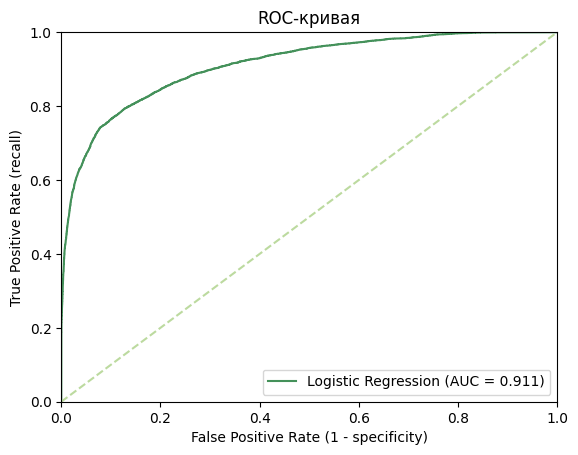

In [ ]:
plt.plot(fpr, tpr, color='#44915a', label='Logistic Regression (AUC = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='#bcda9f', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

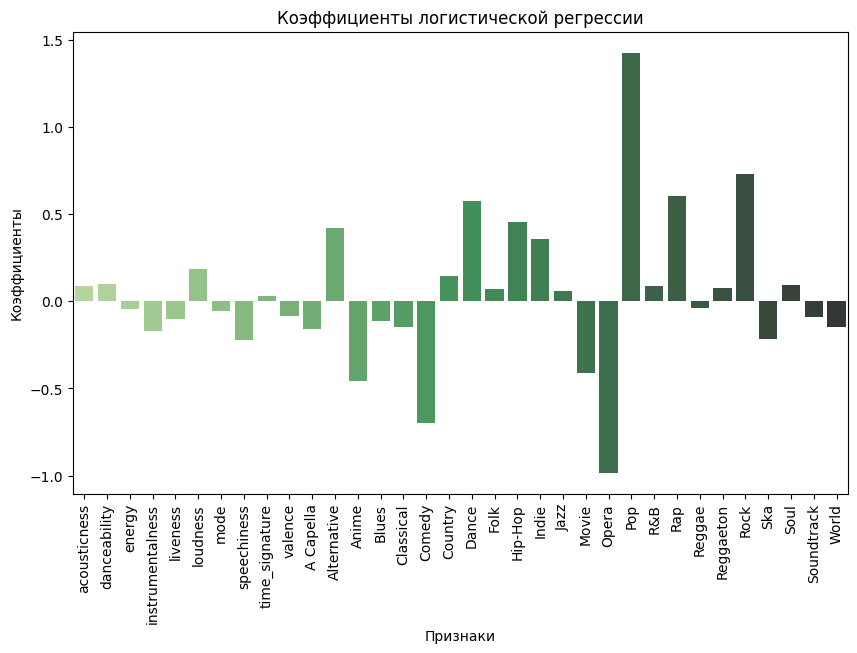

In [ ]:
features = list(X_log.columns)
weights = log_model.coef_.ravel()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=features, y=weights, ax=ax,  palette='YlGn_d')

ax.set_title('Коэффициенты логистической регрессии')
ax.set_xlabel('Признаки')
ax.set_ylabel('Коэффициенты')

plt.xticks(rotation=90)
plt.show()

# Построение второй модели

В качестве второй модели был выбран алгоритм **k-ближайших соседей**. 

### Подбор гиперпараметров

In [ ]:
n_neighbors = [3, 5, 7]
weights = ['uniform', 'distance']
metric = ['euclidean', 'minkowski']

cv = StratifiedKFold(10)

knn_model = KNeighborsClassifier()
grid_knn = GridSearchCV(estimator=knn_model, cv=cv, 
                        param_grid=dict(n_neighbors=n_neighbors, metric=metric,
                                        weights=weights))
grid_knn.fit(X_train_sc, y_train)
print("best score: ", grid_knn.best_score_)
print("best param: ", grid_knn.best_params_)
print("test score:", grid_knn.score(X_test_sc, y_test))

best score:  0.885708415829499
best param:  {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
test score: 0.8875123744873427


In [ ]:
knn_model = KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='uniform')
knn_model.fit(X_train_sc, y_train)

y_pred_knn = knn_model.predict(X_test_sc)
model_acc['K-Nearest Neighbour'] = knn_model.score(X_test_sc, y_test)

print('Accuracy: %2.3f' % accuracy_score(y_test, y_pred_knn))

Accuracy: 0.888


# Построение третьей модели

В качестве третьей модели было выбрано **Дерево принятия решений**. Эта модель может обрабатывать нелинейные зависимости, но может быть склонна к переобучению.


### Выбор подмножества параметров

In [ ]:
rfecv = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train, y_train)

selected_features_dtc = list(rfecv.get_feature_names_out(X.columns))

print('Оптимальное количество параметров: %d' % rfecv.n_features_)
print('Выбранные параметры: %s' % selected_features_dtc)

Оптимальное количество параметров: 34
Выбранные параметры: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'feat_count', 'Alternative', 'Blues', "Children's Music", 'Country', 'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Opera', 'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul', 'World']


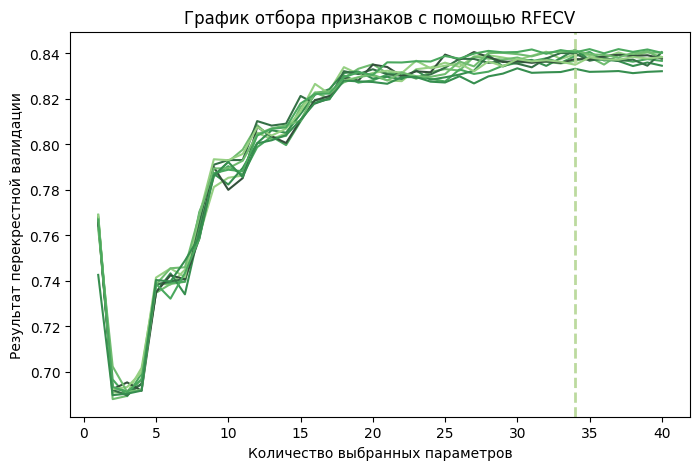

In [ ]:
results = rfecv.cv_results_.copy()
del results['mean_test_score']
del results['std_test_score']

plt.figure(figsize=(8,5))
plt.title('График отбора признаков с помощью RFECV')
plt.xlabel('Количество выбранных параметров')
plt.ylabel('Результат перекрестной валидации')

for metric, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, label=metric)

plt.axvline(x=rfecv.n_features_, color='#bcda9f', linestyle='--', linewidth=2)
plt.show()

In [ ]:
X_dtc = X[selected_features_dtc]
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(X_dtc, y, test_size = 0.2, random_state=73)

### Подбор гиперпараметров

In [ ]:
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

cv = StratifiedKFold(10)

dtc_model = DecisionTreeClassifier(random_state=73)
grid_dtc = GridSearchCV(estimator=dtc_model, cv=cv, 
        param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                        max_features= max_features))
grid_dtc.fit(X_train_dtc, y_train_dtc)
print("best score: ", grid_dtc.best_score_)
print("best param: ", grid_dtc.best_params_)
print("test score:", grid_dtc.score(X_test_dtc, y_test_dtc))

best score:  0.8922351345162417
best param:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'random'}
test score: 0.8926601612218923


### Построение модели

In [ ]:
dtc_model = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=8,
                                   min_samples_leaf=6, min_samples_split=2,
                                   splitter='random', random_state=73)
dtc_model.fit(X_train_dtc, y_train_dtc)

y_pred_dtc = dtc_model.predict(X_test_dtc)
y_pred_proba = dtc_model.predict_proba(X_test_dtc)[:, 1]  # предсказываем вероятность по классам
model_acc['Decision Tree'] = dtc_model.score(X_test_dtc, y_test_dtc)
[fpr, tpr, thr] = roc_curve(y_test_dtc, y_pred_proba)

print('Accuracy: %2.3f' % accuracy_score(y_test_dtc, y_pred_dtc))
print('Log Loss: %2.3f' % log_loss(y_test_dtc, y_pred_proba))
print('AUC: %2.3f' % auc(fpr, tpr))

Accuracy: 0.893
Log Loss: 0.308
AUC: 0.880



*   Значение **Log Loss**, хоть и выше, чем у логистической регрессии, но невелико; модель имеет высокую точность предсказания
*   Значение **AUC**, равное 0.88,  указывает на высокое качество модели классификации, однако не такое высокое, как у логистической регрессии

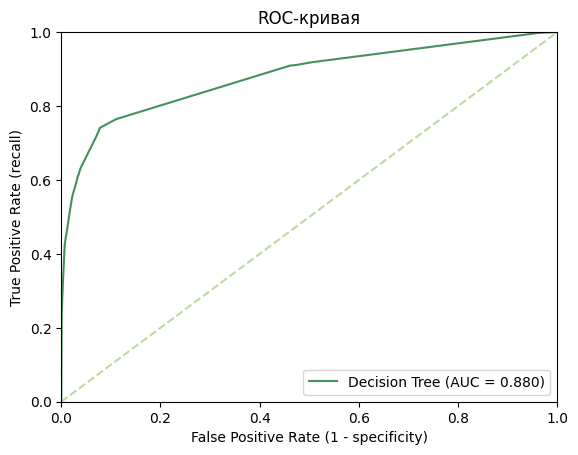

In [ ]:
plt.plot(fpr, tpr, color='#44915a', label='Decision Tree (AUC = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='#bcda9f', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

Выведем дерево решений в файл Spotify.pdf 

In [ ]:
final_decision_tree = grid_dtc.best_estimator_
dot_data = tree.export_graphviz(final_decision_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render('Spotify')

'Spotify.pdf'

# Результаты

## Точность

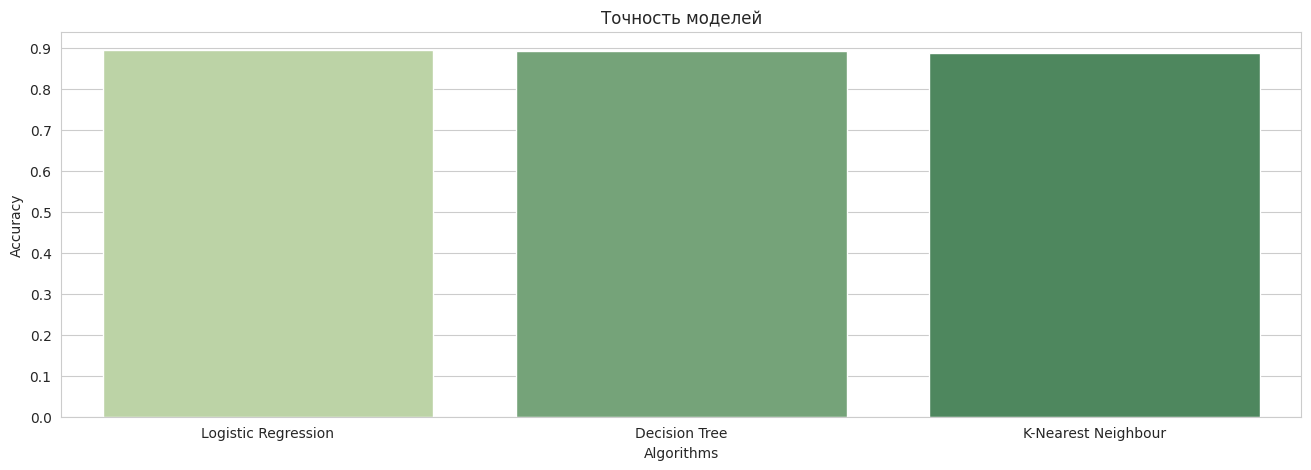

In [ ]:
colors = ['#bcda9f', '#6dab72', '#44915a']

sns.set_style("whitegrid")

plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel('Accuracy')
plt.xlabel('Algorithms')
plt.title('Точность моделей')
sns.barplot(x=list(model_acc.keys()), y=list(model_acc.values()), palette=colors)
plt.show()

Разница в точности между моделями незначительна:

* Логистическая регрессия - 0.894
* Дерево принятия решений - 0.893
* Алгоритм k-ближайших соседей - 0.888


## Матрица путаницы

In [ ]:
cm_log = confusion_matrix(y_test, y_pred_log)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_dtc = confusion_matrix(y_test, y_pred_dtc)

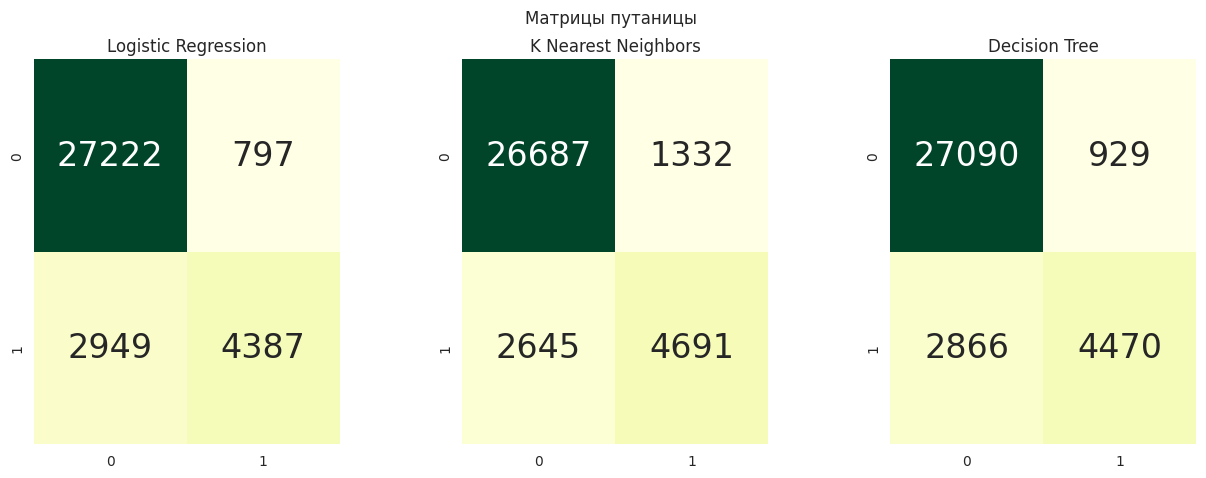

In [ ]:
plt.figure(figsize=(15, 5))

plt.suptitle('Матрицы путаницы', x=0.51)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(1,3,1)
plt.title('Logistic Regression')
sns.heatmap(cm_log,annot=True,cmap='YlGn',fmt='d',cbar=False, annot_kws={'size': 24})

plt.subplot(1,3,2)
plt.title('K Nearest Neighbors')
sns.heatmap(cm_knn,annot=True,cmap='YlGn',fmt='d',cbar=False, annot_kws={'size': 24})

plt.subplot(1,3,3)
plt.title('Decision Tree')
sns.heatmap(cm_dtc,annot=True,cmap='YlGn',fmt='d',cbar=False, annot_kws={'size': 24})
plt.show()


Заметим, что все модели чаще классифицировали популярные песни как непопулярные, чем непопулярные как популярные.